In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
# Load example data
data_df = mavenn.load_example_dataset('gb1')

# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')
data_df.head()

test N: 26,364
training + validation N: 504,373


,set,dist,input_ct,selected_ct,y,x
0,training,2,173,33,-3.145154,AAKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
1,training,2,18,8,-1.867676,ACKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
2,training,2,66,2,-5.270800,ADKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
3,training,2,72,1,-5.979498,AEKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
4,training,2,69,168,0.481923,AFKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...


In [3]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y']

In [4]:
L

55

In [5]:
# instantiate gpmap object
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

# get test set data.
x_test = test_df['x'].values
y_test = test_df['y'].values

2022-03-28 23:28:10.588700: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Create measurement process object(s)

In [6]:
mp_GE = mavenn.measurement_process_layers.GlobalEpsitasisMP(K=20)

In [7]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=[mp_GE])

In [8]:
# Set training data
model.set_data(x=data_df['x'],
               y_list=[data_df['y'].values],
               #validation_flags=(data_df['set']=='validation'),
               shuffle=False)

N = 504,373 observations set as training data.
Using 19.9% for validation.
Time to set data: 25.0 sec.


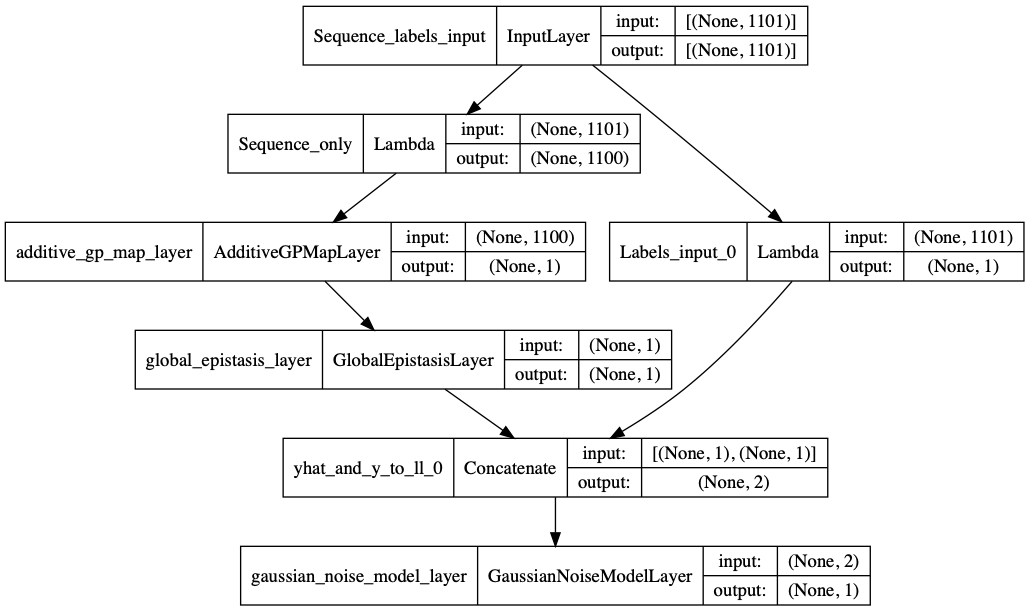

In [9]:
from tensorflow.keras.utils import plot_model
plot_model(model.model,show_shapes=True)

In [10]:
# Fit model to data
history = model.fit(learning_rate=.0005,
                    epochs=20,
                    batch_size=1000,
                    try_tqdm=False,
                    early_stopping=True,
                    early_stopping_patience=5,
                    linear_initialization=False)

Epoch 1/20
404/404 [==============================] - 7s 14ms/step - loss: 1402.5745 - I_var: -0.2623 - val_loss: 1278.7688 - val_I_var: -0.0860
Epoch 2/20
404/404 [==============================] - 2s 6ms/step - loss: 1032.5311 - I_var: 0.2720 - val_loss: 740.3630 - val_I_var: 0.6918
Epoch 3/20
404/404 [==============================] - 3s 7ms/step - loss: 563.8981 - I_var: 0.9481 - val_loss: 427.7120 - val_I_var: 1.1438
Epoch 4/20
404/404 [==============================] - 3s 7ms/step - loss: 331.7413 - I_var: 1.2831 - val_loss: 244.2240 - val_I_var: 1.4092
Epoch 5/20
404/404 [==============================] - 3s 7ms/step - loss: 178.8176 - I_var: 1.5038 - val_loss: 124.0150 - val_I_var: 1.5832
Epoch 6/20
404/404 [==============================] - 2s 6ms/step - loss: 86.0329 - I_var: 1.6377 - val_loss: 59.0390 - val_I_var: 1.6774
Epoch 7/20
404/404 [==============================] - 2s 5ms/step - loss: 40.8609 - I_var: 1.7029 - val_loss: 31.3688 - val_I_var: 1.7175
Epoch 8/20
404/404

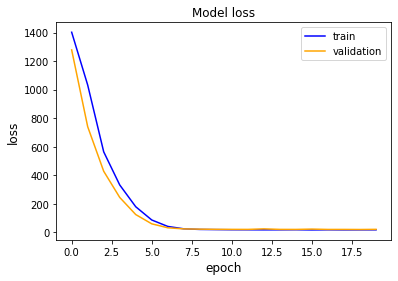

In [11]:
plt.plot(model.history['loss'], color='blue')
plt.plot(model.history['val_loss'], color='orange')
plt.title('Model loss', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['train', 'validation'])

In [12]:
phi = gpmap.x_to_phi(x_test)
mp_GE.phi_to_yhat(phi)

<tf.Tensor: shape=(26364, 1), dtype=float32, numpy=
array([[-0.54601383],
       [ 0.38638014],
       [-0.63471794],
       ...,
       [ 0.17348331],
       [-0.00720906],
       [-0.05605301]], dtype=float32)>

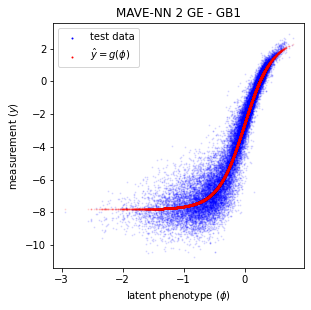

In [13]:
fig, ax = plt.subplots(figsize=(4.5,4.5))
yhat = mp_GE.phi_to_yhat(phi)
ax.scatter(phi,y_test,s=1,alpha=0.1,c='b',label='test data')
ax.scatter(phi,yhat* model.y_std+model.y_mean,s=1,alpha=0.1,c='r',label='$\hat{y} = g(\phi)$')

ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('MAVE-NN 2 GE - GB1')
leg = ax.legend()

for lh in leg.legendHandles: 
    lh.set_alpha(1)